# Non-negative integration of gene expression and chromatin accessibility of 10k PBMCs

This notebook demonstrates how to apply a non-negative version (experimental) of `MuVI` on multiple modalities, e.g. RNA-seq and ATAC-seq, in order to infer a joint latent space that is informed a priori by existing domain knowledge in terms of gene set annotations.

This tutorial extends the excellent [muon-tutorial](https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/pbmc10k/3-Multimodal-Omics-Data-Integration.html) on applying [MOFA](https://biofam.github.io/MOFA2/) to single-cell gene expression and chromatin accessibility for inferring a joint latent space across multiple modalities.
Please refer to [this tutorial](https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/pbmc10k/1-Gene-Expression-Processing.html) for processing the RNA modality, and [this tutorial](https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/pbmc10k/2-Chromatin-Accessibility-Processing.html) for processing the ATAC modality.

In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import muon as mu

/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch

In [4]:
# import muvi

from famo.core import CORE
from famo.utils_gpu import get_free_gpu_idx
from famo.plotting import (
    plot_factor,
    plot_factor_correlation,
    plot_top_weights,
    plot_training_curve,
    plot_variance_explained,
    plot_weights,
)

In [5]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: <object object at 0x7f212ad6a9f0>


In [6]:
# plotting settings
# sns.set()
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("notebook")

Run a quick check if GPU(s) are available and select the least utilized GPU to perform the optimization.

In [7]:
device = "cpu"
try:
    device = f"cuda:{get_free_gpu_idx()}"
except Exception as e:
    print(e)
device

'cuda:1'

Load the MuData object from the `.h5mu` file:

In [8]:
adata = sc.read_h5ad("../../../data/muvi/kang_pp.h5ad")
adata

AnnData object with n_obs × n_vars = 13576 × 979
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type'
    uns: 'condition_colors', 'terms'
    varm: 'gene_set_mask'

In [9]:
center = False
if center:
    adata.X = adata.X - np.nanmean(adata.X, axis=0)
else:
    adata.X = adata.X - np.nanmin(adata.X, axis=0)
print(f"Current shape: {adata.shape}")
global_std = np.nanstd(adata.X)
print(f"Global std before: {global_std}")
adata.X /= global_std
print(f"Global std : {np.nanstd(adata.X)}")

Current shape: (13576, 979)
Global std before: 1.3638088703155518
Global std : 0.9999994039535522


<Axes: >

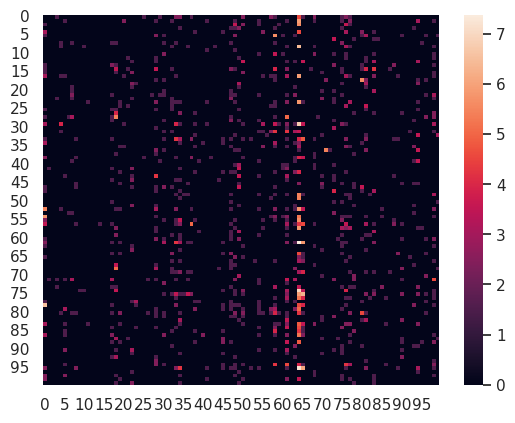

In [10]:
# visual check
sns.heatmap(adata.X[:100, :100])

For this analysis we extract the prior information from well established databases of gene set collections such as the [MSigDB](http://www.gsea-msigdb.org/gsea/msigdb) and [Reactome](https://reactome.org/). We keep only those gene set annotations with at least 15 genes, and where at least 10% of the genes are available in the set of genes from RNA.

In [11]:
from famo import feature_sets

In [12]:
def to_upper(feature_set_collection):
    return feature_sets.FeatureSets(
        [
            feature_sets.FeatureSet([f.upper() for f in fs], fs.name)
            for fs in feature_set_collection
        ],
        name=feature_set_collection.name,
    )

In [13]:
# reactome_collection = feature_sets.from_gmt(
#     "../../muvi-framework/msigdb/m2.cp.reactome.v2023.2.Mm.symbols.gmt", name="reactome"
# )

# gene_set_collection = reactome_collection
# gene_set_collection = to_upper(gene_set_collection)
# gene_set_collection

We keep only those gene set annotations with at least 15 genes, and where at least 10% of the genes are available in the set of genes from RNA.

In [14]:
# gene_set_collection = gene_set_collection.filter(
#     adata.var_names, min_fraction=0.1, min_count=15, max_count=300
# )
# # sorted([fs.name for fs in gene_set_collection])
# gene_set_collection

In [15]:
# gene_set_collection.median_size

Generally, the gene set collections inform different views differently. That is, some gene sets may inform a single view only, while other gene sets inform both views jointly. Therefore, we store the prior information into the corresponding `AnnData` inside the `MuData` object. 

In our case, we may only inform the RNA view, and expect the ATAC view to be informed implicitly during the inference of shared latent factors.

Finally, we convert the prior information into a numerical representation such as a binary matrix.

In [16]:
# adata.varm["gene_set_mask"] = gene_set_collection.to_mask(adata.var_names.tolist()).T

n_dense = 3
dense_cols = [f"DENSE_{k}" for k in range(n_dense)]
adata.varm["gene_set_mask"] = pd.concat(
    [
        pd.DataFrame(True, index=adata.var_names, columns=dense_cols),
        adata.varm["gene_set_mask"],
    ],
    axis=1,
)

In [17]:
# Run model with MuData object
model = CORE(device=device)

Setting up device...
- Running all computations on `cuda:1`


In [18]:
model.fit(
    data=mu.MuData({"rna": adata}),
    # n_factors=15,
    # annotations={
    #     "rna": torch.Tensor(mdata["rna"].varm["gene_set_mask"].T.values).to(model.device),
    #     "prot": torch.Tensor(mdata["prot"].varm["gene_set_mask"].T.values).to(model.device),
    # },
    annotations={
        "rna": adata.varm["gene_set_mask"].T,
    },
    # Likelihoods will be inferred automatically from the data if not provided
    # FIXME: This needs to be set to Bernoulli
    likelihoods={
        "rna": "Normal",
    },
    nmf={
        "rna": not center,
    },
    factor_prior="Normal",
    weight_prior="Horseshoe",
    prior_penalty=0.005,
    # weight_prior="ARD_Spike_and_Slab",
    lr=0.005,
    early_stopper_patience=100,
    print_every=500,
    scale_per_group=False,
    max_epochs=5000,
    save=False,
    save_path=None,
    init_factors="random",
    init_scale=0.1,
    seed=0,
)

Fitting model...
- Checking compatibility of provided likelihoods with data.
  - rna: Normal
- Anchoring group_1/rna...


alt.Chart(...)

Initializing factors using `random` method...
{'rna': 1.0}
Decaying learning rate over 5000 iterations.
Setting training seed to `0`.
Cleaning parameter store.
Epoch:       0 | Time:       2.63s | Loss:    4236.62
Epoch:     500 | Time:      32.75s | Loss:     593.02
Epoch:    1000 | Time:      64.05s | Loss:     416.81
Epoch:    1500 | Time:      96.37s | Loss:     358.15
Epoch:    2000 | Time:     128.59s | Loss:     327.06
Epoch:    2500 | Time:     160.58s | Loss:     309.30
Epoch:    3000 | Time:     193.49s | Loss:     298.51
Epoch:    3500 | Time:     227.13s | Loss:     290.70
Epoch:    4000 | Time:     261.19s | Loss:     286.06
Epoch:    4500 | Time:     295.95s | Loss:     282.54
Training finished after 4741 steps.


In [19]:
# model._post_fit(False, None)

In [20]:
(model.data["group_1"]["rna"].var_names == adata.varm["gene_set_mask"].index).all()

True

In [21]:
# model.factor_names = mdata["rna"].varm["gene_set_mask"].columns.copy()

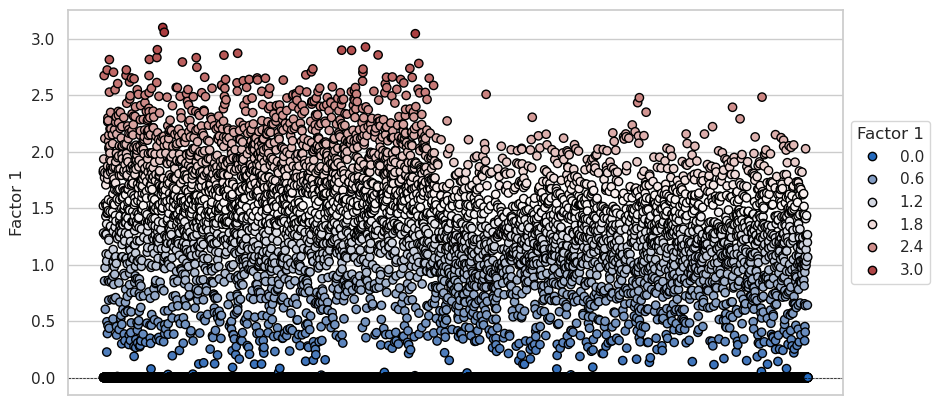

In [22]:
plot_factor(model)

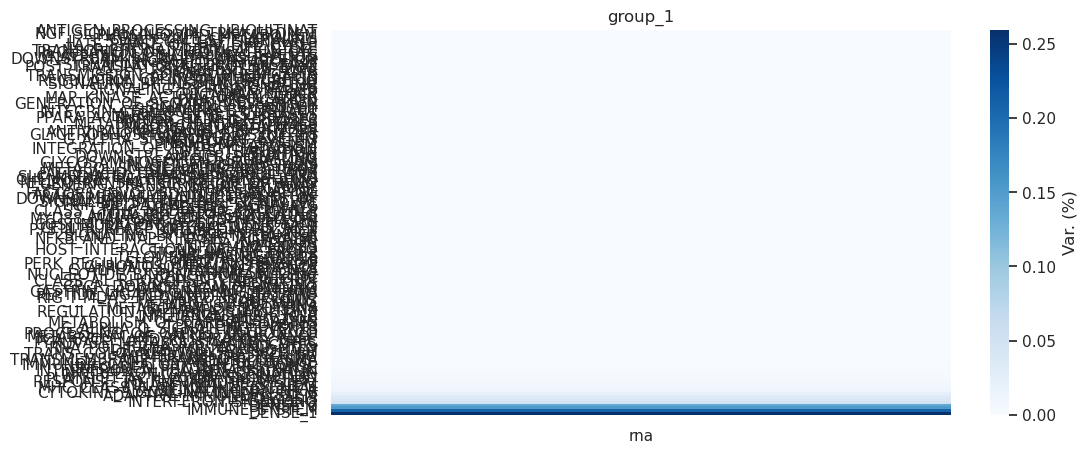

In [23]:
plot_variance_explained(model)

In [24]:
from famo import plotting

In [25]:
model._cache["factors"] = model.get_factors("anndata")
model._cache["factors"]

{'group_1': AnnData object with n_obs × n_vars = 13576 × 137
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type'}

In [26]:
[fn for fn in model.factor_names if "B_CELL" in fn]

['SIGNALING_BY_THE_B_CELL_RECEPT']

In [27]:
sc.tl.rank_genes_groups(
    model._cache["factors"]["group_1"], "cell_type", method="wilcoxon"
)

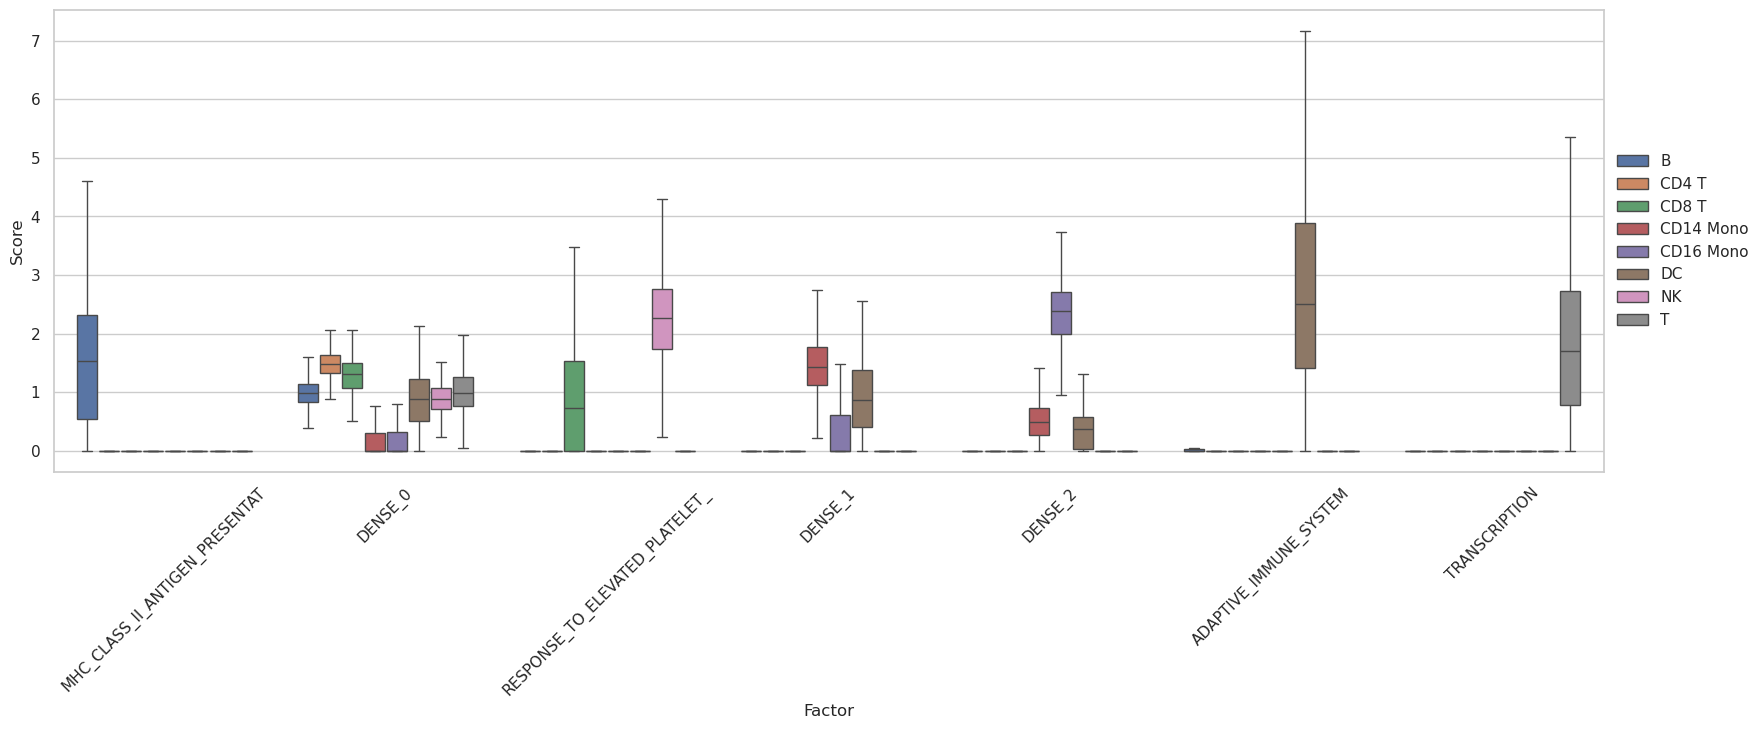

In [28]:
plt.figure(figsize=(20, 6))
relevant_factors, _ = plotting.groupplot_rank(
    model, pl_type=plotting.BOXPLOT, top=1, gap=0.1, showfliers=False
)

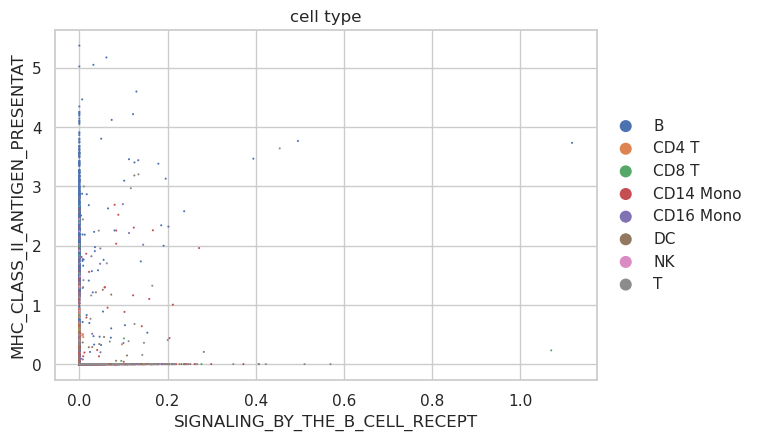

In [29]:
plotting.scatter(
    model,
    x="SIGNALING_BY_THE_B_CELL_RECEPT",
    y="MHC_CLASS_II_ANTIGEN_PRESENTAT",
    groupby="cell_type",
)

(<Figure size 800x5600 with 7 Axes>,
 array([[<Axes: title={'center': 'MHC_CLASS_II_ANTIGEN_PRESENTAT (rna)'}, xlabel='Rank', ylabel='Loading'>],
        [<Axes: title={'center': 'DENSE_0 (rna)'}, xlabel='Rank', ylabel='Loading'>],
        [<Axes: title={'center': 'RESPONSE_TO_ELEVATED_PLATELET_ (rna)'}, xlabel='Rank', ylabel='Loading'>],
        [<Axes: title={'center': 'DENSE_1 (rna)'}, xlabel='Rank', ylabel='Loading'>],
        [<Axes: title={'center': 'DENSE_2 (rna)'}, xlabel='Rank', ylabel='Loading'>],
        [<Axes: title={'center': 'ADAPTIVE_IMMUNE_SYSTEM (rna)'}, xlabel='Rank', ylabel='Loading'>],
        [<Axes: title={'center': 'TRANSCRIPTION (rna)'}, xlabel='Rank', ylabel='Loading'>]],
       dtype=object))

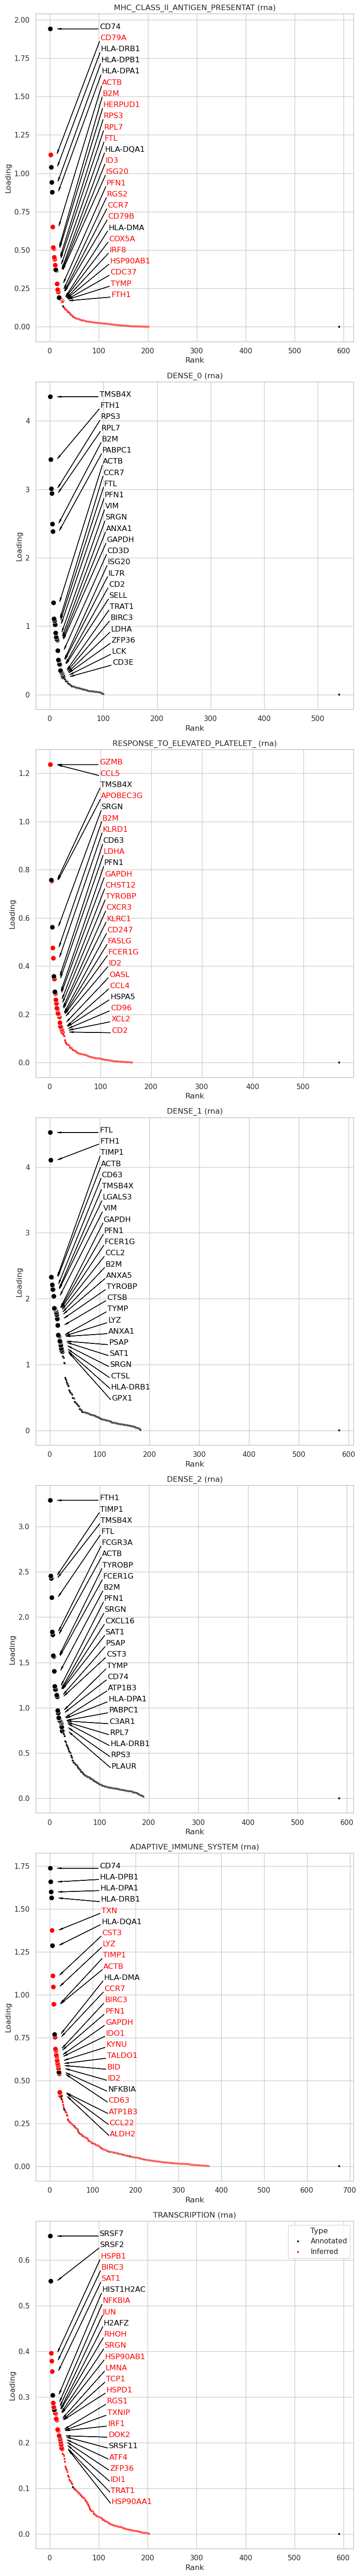

In [30]:
plotting.plot_top_weights(model, factor_idx=relevant_factors)

In [31]:
sc.pl.rank_genes_groups_dotplot(adata_latent, n_genes=3)

NameError: name 'adata_latent' is not defined

In [ ]:
sc.pp.neighbors(adata_latent, use_rep="X")
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)

In [ ]:
adata_latent.obs

In [ ]:
sc.pl.umap(
    adata_latent,
    color=["leiden", "rna:batch_indices", "cell types (high)", "rna:cell_types"],
)

In [ ]:
sc.pl.scatter(
    adata_latent, x="DENSE_0", y="DENSE_2", color="rna:batch_indices", size=50
)

In [ ]:
sc.pl.scatter(
    adata_latent, x="DENSE_1", y="DENSE_2", color="rna:batch_indices", size=50
)

In [ ]:
sorted(model._cache.factor_adata.obs["cell_types"].unique())

In [ ]:
model._cache.factor_adata.obs["CD4_vs_rest"] = (
    model._cache.factor_adata.obs["cell_types"]
    .isin(["Activated CD4 T", "CD4 T", "Ifit3-high CD4 T"])
    .astype("category")
)
model._cache.factor_adata.obs["CD8_vs_rest"] = (
    model._cache.factor_adata.obs["cell_types"]
    .isin(["CD122+ CD8 T", "CD8 T", "Ifit3-high CD8 T"])
    .astype("category")
)

In [ ]:
model._cache.factor_adata.obs.head()

In [ ]:
# shuffled_obs = adata.obs_names[np.random.permutation(adata.n_obs)]
# model._cache.factor_adata = model._cache.factor_adata[shuffled_obs, :].copy()

After copying the metadata stored in `mdata.obs`, we may perform a typical `scanpy` analysis such as computing a neighborhood graph in the latent space, applying a clustering algorithm on the pathway level, and embedding the neighborhood graph in two dimensions for visualization purposes. 

Optionally, we may filter only the relevant factors before performing the steps mentioned above. This is useful to reduce the number of factors involved in the analysis by removing factors that explain little to no variance in the data.

In [ ]:
# muvi.tl.filter_factors(model, r2_thresh=0.95)
# model._cache.factor_adata.obsm['filtered_scores'] = model._cache.factor_adata.to_df().copy()
# model._cache.factor_adata.obsm['filtered_scores'] = model._cache.factor_adata.to_df().iloc[:, -n_dense:].copy()
model._cache.factor_adata.obsm["filtered_scores"] = (
    model._cache.factor_adata.to_df().iloc[:, :-n_dense].copy()
)

In [ ]:
# model._cache.factor_adata.obsm["filtered_scores"] = model._cache.factor_adata.obsm["filtered_scores"].loc[:, [col for col in model._cache.factor_adata.obsm["filtered_scores"].columns if "Uninformed" not in col]].copy()

In [ ]:
model._cache.factor_adata.obsm["filtered_scores"].columns[:10]

In [ ]:
muvi.tl.neighbors(model)
muvi.tl.leiden(model)
muvi.tl.umap(model)

In [ ]:
model._cache.factor_adata.obs["batch"]

In [ ]:
groupby = "leiden"
# color = [groupby] + model._cache.factor_adata.obs.columns.tolist()
color = ["cell_types"]
# color = ["batch_indices"]
# color = ["batch"]
muvi.pl.umap(
    model, color, s=8, legend_loc="on data", na_in_legend=False, legend_fontsize=4
)

The inferred latent space captures major axes of variation such as different cell types. Next, we look into specific factors (pathways) that explain variance within specific cell types. 

In [ ]:
for cat_col in [
    "batch",
    "tissue",
    "cell_types",
    # "source",
    # "T Cells",
    # "CD4_vs_rest",
    # "CD8_vs_rest",
]:
    model._cache.factor_adata.obs[cat_col] = model._cache.factor_adata.obs[
        cat_col
    ].astype("category")

In [ ]:
cell_type_map = {
    "Mature B": "B",
    "Transitional B": "B",
    "Ifit3-high B": "B",
    "MZ B": "B",
    "B1 B": "B",
    "Plasma B": "B",
    "CD4 T": "CD4",
    "Ifit3-high CD4 T": "CD4",
    "Activated CD4 T": "CD4",
    "CD8 T": "CD8",
    "CD122+ CD8 T": "CD8",
    "Ifit3-high CD8 T": "CD8",
    "Tregs": "Tregs",
    "ICOS-high Tregs": "Tregs",
    # 'GD T': 'GD T',
    "NKT": "NK",
    "NK": "NK",
    "Neutrophils": "Neutrophils",
    "Ly6-high mono": "Ly6",
    "Ly6-low mono": "Ly6",
    "cDC2s": "DC",
    "cDC1s": "DC",
    "Migratory DCs": "DC",
    "pDCs": "DC",
    "Erythrocytes": "Erythrocytes",
    "MZ/Marco-high macrophages": "Macrophages",
    "Red-pulp macrophages": "Macrophages",
}


# cell_type_map = {'Mature B': 'B',
#  'CD4 T': 'T',
#  'CD8 T': 'T',
#  'Transitional B': 'B',
#  'CD122+ CD8 T': 'T',
#  'Ifit3-high B': 'B',
#  'MZ B': 'B',
#  'Ifit3-high CD4 T': 'T',
#  'B1 B': 'B',
#  'Tregs': 'T',
#  'NKT': 'NK',
#  'ICOS-high Tregs': 'T',
#  'Ifit3-high CD8 T': 'T',
#  'NK': 'NK',
#  'Neutrophils': 'Neutrophils',
#  'cDC2s': 'DC',
#  'GD T': 'T',
#  'Ly6-high mono': 'Ly6',
#  'cDC1s': 'DC',
#  'MZ/Marco-high macrophages': 'Macrophages',
#  'Migratory DCs': 'DC',
#  'Activated CD4 T': 'T',
#  'pDCs': 'DC',
#  'Red-pulp macrophages': 'Macrophages',
#  'Ly6-low mono': 'Ly6',
#  'Erythrocytes': 'Erythrocytes',
#  'Plasma B': 'B'}

model._cache.factor_adata.obs["cell types (high)"] = (
    model._cache.factor_adata.obs["cell_types"].map(cell_type_map).astype("category")
)

In [ ]:
from IPython.display import display, Latex

In [ ]:
# for k in sorted(cell_type_map):
#     display(Latex(f"{k} $\\rightarrow$ {cell_type_map[k]}"))

In [ ]:
meta_col = "batch"
muvi.tl.dendrogram(model, meta_col)
muvi.tl.rank(model, meta_col, method="wilcoxon")
muvi.pl.rank(model, n_factors=3, pl_type="matrixplot")

In [ ]:
meta_col = "cell types (high)"
# meta_col = "cell_types"

In [ ]:
muvi.tl.dendrogram(model, meta_col)
muvi.tl.rank(model, meta_col, method="wilcoxon")
muvi.pl.rank(model, n_factors=3, pl_type="matrixplot")

In [ ]:
# muvi.pl.scatter(model, x='Oxidative Phosphorylation (H)', y='Myc Targets V1 (H)', groupby=meta_col)

In [ ]:
groups = None
if meta_col == "cell_types":
    groups = model._cache.factor_adata.obs["cell_types"].value_counts()
    groups = groups[groups > 200].index.tolist()
groups

In [ ]:
# plotting settings
sns.set()
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper")

In [ ]:
# muvi.pl.scatter(model, "Celltype Mesenchymal Stem Cell", "Celltype Embryonic Stem Cell", groupby="batch")

In [ ]:
# muvi.pl.scatter(model, "Han Myeloid Progenitor Cell", "Han Myocyte", groupby="batch")

In [ ]:
muvi.pl.scatter(model, "Uninformed 1", "Uninformed 2", groupby="batch")

In [ ]:
g_dict = muvi.pl.scatter_rank(model, groups, size=4, show=False)
for k, g in g_dict.items():
    g.set_title("batch")

In [ ]:
model._cache.factor_adata.obs["cell_types"].value_counts()

In [ ]:
groups = None
if meta_col == "cell_types":
    groups = model._cache.factor_adata.obs["cell_types"].value_counts()
    # groups = groups[groups > 200].index.tolist()
    groups = groups.iloc[0:8].index.tolist()
groups
plt.figure(figsize=(12, 3))
relevant_factors, g = muvi.pl.groupplot_rank(
    model,
    groups,
    pl_type="boxplot",
    top=1,
    include_rest=True,
    rot=15,
    # gap=.1,
    fliersize=1,
    showfliers=False,
)

In [ ]:
sorted(model._cache.factor_adata.obs["cell_types"].unique().tolist())

In [ ]:
nkt_cells = [
    "Activated CD4 T",
    "CD122+ CD8 T",
    "CD4 T",
    "CD8 T",
    "GD T",
    "ICOS-high Tregs",
    "Ifit3-high CD4 T",
    "Ifit3-high CD8 T",
    "NK",
    "NKT",
    "Tregs",
]

In [ ]:
b_cells = [
    "B1 B",
    "Ifit3-high B",
    "MZ B",
    "Mature B",
    "Plasma B",
    "Transitional B",
]

In [ ]:
model._cache.factor_adata.obs["cell_types_nkt_vs_rest"] = model._cache.factor_adata.obs[
    "cell_types"
].astype(str)
model._cache.factor_adata.obs.loc[
    ~model._cache.factor_adata.obs["cell_types_nkt_vs_rest"].isin(nkt_cells),
    "cell_types_nkt_vs_rest",
] = "Other"
model._cache.factor_adata.obs["cell_types_nkt_vs_rest"] = model._cache.factor_adata.obs[
    "cell_types_nkt_vs_rest"
].astype("category")

In [ ]:
model._cache.factor_adata.obs["cell_types_b_vs_rest"] = model._cache.factor_adata.obs[
    "cell_types"
].astype(str)
model._cache.factor_adata.obs.loc[
    ~model._cache.factor_adata.obs["cell_types_b_vs_rest"].isin(b_cells),
    "cell_types_b_vs_rest",
] = "Other"
model._cache.factor_adata.obs["cell_types_b_vs_rest"] = model._cache.factor_adata.obs[
    "cell_types_b_vs_rest"
].astype("category")

In [ ]:
color_mapper = dict(
    zip(
        model._cache.factor_adata.obs["cell_types"].cat.categories,
        model._cache.factor_adata.uns["cell_types_colors"],
    )
)
nkt_cells_colors = [color_mapper[c] for c in nkt_cells]
b_cells_colors = [color_mapper[c] for c in b_cells]

model._cache.factor_adata.uns["cell_types_nkt_vs_rest_colors"] = nkt_cells_colors + [
    "#808080"
]
model._cache.factor_adata.uns["cell_types_b_vs_rest_colors"] = b_cells_colors + [
    "#808080"
]
b_cells_colors

In [ ]:
relevant_factors

In [ ]:
rf = "Marginal Zone B Cell (H)"

plt.figure(figsize=(12, 5))
g = muvi.pl.boxplot(
    model,
    rf,
    groupby="cell_types_b_vs_rest",
    hue_order=b_cells + ["Other"],
    groups=None,
    include_rest=True,
    rot=0,
    # gap=.1,
    fliersize=1,
    showfliers=True,
    legend_fontsize=8,
    show=False,
)
# g.legend(fontsize=6)
g.set_xlabel("")
plt.show()
muvi.pl.inspect_factor(model, rf, view_idx="rna", top=20, figsize=(4, 8))

In [ ]:
rf = "T Cell (H)"

plt.figure(figsize=(12, 5))
g = muvi.pl.boxplot(
    model,
    rf,
    groupby="cell_types_nkt_vs_rest",
    hue_order=nkt_cells + ["Other"],
    groups=None,
    include_rest=True,
    rot=0,
    # gap=.1,
    fliersize=1,
    showfliers=True,
    legend_fontsize=8,
    show=False,
)
# g.legend(fontsize=6)
g.set_xlabel("")
plt.show()
muvi.pl.inspect_factor(model, rf, view_idx="rna", top=20, figsize=(4, 8))

In [ ]:
plt.figure(figsize=(8, 5))
g = muvi.pl.boxplot(
    model,
    "Han Marginal Zone B Cell",
    groupby="cell_types",
    groups=None,
    include_rest=True,
    rot=0,
    gap=0.1,
    fliersize=1,
    showfliers=True,
    legend_fontsize=8,
    show=False,
)
# g.legend(fontsize=6)
g.set_xlabel("")
plt.show()

In [ ]:
model._cache.factor_adata.obs["cell_types"].value_counts()

In [ ]:
model.factor_names

In [ ]:
# ax_dict = muvi.pl.scatter_rank(model, groups, include_rest=True, size=2)
# plt.show()

In [ ]:
# tcr_scores = model._cache.factor_adata.to_df().loc[:, 'Tcr Signaling (R)'].copy()
# tcr_scores > 1.0

In [ ]:
# col = 'tissue'
# print(model._cache.factor_adata.obs.loc[tcr_scores > 1.0, col].value_counts())
# print(model._cache.factor_adata.obs.loc[(tcr_scores > 0.0) & (tcr_scores < 1.0), col].value_counts())

In [ ]:
# test_df = pd.concat([model._cache.factor_adata.to_df().iloc[:, -3:], model._cache.factor_adata.obs[[meta_col]]], axis=1)
# test_df[meta_col].unique()

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# for batch_id in [1, 0]:
#     batch_samples = test_df[meta_col] == batch_id
#     xs = test_df.loc[batch_samples, '0 (D)']
#     ys = test_df.loc[batch_samples, '1 (D)']
#     zs = test_df.loc[batch_samples, '2 (D)']
#     ax.scatter(xs, ys, zs, marker={0: 'o', 1:'^'}[batch_id], s=1)

# ax.set_xlabel('0 (D)')
# ax.set_ylabel('1 (D)')
# ax.set_zlabel('2 (D)')

# ax.view_init(elev=45, azim=45, roll=None)

# plt.show()

In [ ]:
# relevant_factors = []
# for k, ax in ax_dict.items():
#     relevant_factors.append(str(ax.get_xlabel()))
#     relevant_factors.append(str(ax.get_ylabel()))
# relevant_factors = list(set(relevant_factors))
# relevant_factors

In [ ]:
# # stripplots are much more suitable than scatterplots for non-negative results
# plt.figure(figsize=(10, 5))
# muvi.pl.boxplot(
#     model,
#     relevant_factors,
#     meta_col,
#     groups=groups,
#     include_rest=True,
#     rot=90,
#     gap=.1,
#     fliersize=1,
#     # alpha=0.5,
#     # s=1
# )

To inspect a single factor in a single view regarding its factors loadings, simply call `muvi.pl.inspect_factor`. The features originating from the prior gene set annotation are shown as annotated (black), whereas the new features added during training are shown as inferred (red). As a result, we obtain a data-driven refinement of the prior feature sets.

Optionally, we can map peaks to gene symbols for better readability. Mapping file [pbmc_granulocyte_sorted_10k_atac_peak_annotation.tsv](https://cf.10xgenomics.com/samples/cell-arc/1.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_atac_peak_annotation.tsv) downloaded from 10x Genomics.

In [ ]:
muvi.pl.inspect_factor(
    model,
    # ['Oxidative Phosphorylation (H)', 'Tcr Signaling (R)'],
    # 'Myc Targets V1 (H)',
    # 'Signaling By Gpcr (R)',
    # "Tcr Signaling (R)",
    relevant_factors,
    # "Han Marginal Zone B Cell",
    top=50,
    # figsize=(7, 5)
)

In [ ]:
muvi.pl.inspect_factor(
    model,
    ["Uninformed 0", "Uninformed 1", "Uninformed 2"],
    top=16,
    # figsize=(7, 5)
)

Finally, we may `save` the model on disk and `load` it later to resume the analysis.

In [ ]:
# muvi.save(model, "some_model_output_directory")
# model = muvi.load("some_model_output_directory")

In addition, we may also save the model as a hierarchical data format (HDF5) in order to load it in R, for instance by the `MOFA2` R package.

In [ ]:
# muvi.ext.save_as_hdf5(model, "10x_multiome_muvi.hdf5", save_metadata=True)

Have a look at [this vignette](https://raw.githack.com/MLO-lab/MuVI/master/examples/4_single-cell_multi-omics_integration_R.html) on how to load a `MuVI` model onto `MOFA2` R package for a downstream analysis in R.